In [1]:
import pandas as pd
import numpy as np
import nltk
# nltk.download('punkt')

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors, Word2Vec, FastText
from gensim.models.phrases import Phrases, Phraser
import time
import csv
import io
import scipy
import requests
from PIL import Image
import matplotlib.pyplot as plt
import json
import random
import math

In [2]:
inputSheet = pd.read_csv('cleaned_apiBooks3.csv')
inputSheet.head()

,original_isbn,title,title_long,isbn,isbn13,binding,publisher,language,date_published,edition,pages,dimensions,image,msrp,synopsys,authors,subjects,reviews,prices,related
0,590353403,Harry Potter and the Sorcerer's Stone (1),Harry Potter and the Sorcerer's Stone (1),590353403,9.780590e+12,Hardcover,Scholastic Press,en_US,1998-10T,NaN,309.0,"Height: 9.1 Inches, Length: 6.1 Inches, Weight...",https://images.isbndb.com/covers/34/03/9780590...,0.00,Rescued From The Outrageous Neglect Of His Aun...,"['J.K. Rowling', None]","['Potter, Harry', 'Wizards', 'Wizards--Juvenil...",NaN,NaN,NaN
1,316015849,"Twilight (The Twilight Saga, Book 1)","Twilight (The Twilight Saga, Book 1)",316015849,9.780320e+12,Paperback,"Little, Brown Books for Young Readers",en_US,2006-09-06T00:00:01Z,Reprint,544.0,"Height: 8.25 Inches, Length: 5.5 Inches, Weigh...",https://images.isbndb.com/covers/58/44/9780316...,16.99,With 160 Million Copies Of The Twilight Saga S...,"['Meyer, Stephenie']","['New York Times bestseller', 'nyt:series_book...",NaN,NaN,NaN
2,60935464,To Kill a Mockingbird,To Kill a Mockingbird,60935464,9.780060e+12,Paperback,Harper Perennial,en_US,2002T,NaN,336.0,"Height: 0.9 Inches, Length: 7.9 Inches, Weight...",https://images.isbndb.com/covers/54/67/9780060...,0.00,the Unforgettable Novel Of A Childhood In A Sl...,['Harper Lee'],NaN,NaN,NaN,"{'Kindle Edition': '0062368680', 'eBook': '006..."
3,521402301,F. Scott Fitzgerald: The Great Gatsby (The Cam...,F. Scott Fitzgerald: The Great Gatsby (The Cam...,521402301,9.780520e+12,Hardcover,Cambridge University Press,en_US,1991-08-30T00:00:01Z,Revised ed.,280.0,"Height: 8.7 Inches, Length: 5.84 Inches, Weigh...",https://images.isbndb.com/covers/23/09/9780521...,118.00,Fitzgerald's tale of American values in the ja...,"['Fitzgerald, F. Scott']",NaN,NaN,NaN,NaN
4,452284236,1984,1984,452284236,9.780450e+12,Paperback,Berkley,en_US,2003-05-06T00:00:01Z,Reprint,368.0,"Height: 8.03 Inches, Length: 5.35 Inches, Weig...",https://images.isbndb.com/covers/42/34/9780452...,12.50,Portrays A Terrifying Vision Of Life In The Fu...,['George Orwell'],"['Totalitarianism', 'Totalitarianism--Fiction'...",NaN,NaN,NaN


# Cleaning
These functions handle the cleaning of the descriptions

In [3]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

#Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [4]:
#Applying all abouve functions
cleanDf = pd.DataFrame(columns=['isbn', 'isbn13', 'title', 'synopsys'])

cleanDf['isbn'] = inputSheet['isbn']
cleanDf['isbn13'] = inputSheet['isbn13']
cleanDf['title'] = inputSheet['title']
cleanDf['synopsys'] = inputSheet['synopsys']

cleanDf['cleaned_desc'] = cleanDf['synopsys'].apply(_removeNonAscii)
cleanDf['cleaned_desc'] = cleanDf.cleaned_desc.apply(func = make_lower_case)
cleanDf['cleaned_desc'] = cleanDf.cleaned_desc.apply(func = remove_stop_words)
cleanDf['cleaned_desc'] = cleanDf.cleaned_desc.apply(func = remove_punctuation)
cleanDf['cleaned_desc'] = cleanDf.cleaned_desc.apply(func = remove_html)
cleanDf.head()

,isbn,isbn13,title,synopsys,cleaned_desc
0,590353403,9.780590e+12,Harry Potter and the Sorcerer's Stone (1),Rescued From The Outrageous Neglect Of His Aun...,rescued outrageous neglect aunt uncle young bo...
1,316015849,9.780320e+12,"Twilight (The Twilight Saga, Book 1)",With 160 Million Copies Of The Twilight Saga S...,160 million copies twilight saga sold worldwid...
2,60935464,9.780060e+12,To Kill a Mockingbird,the Unforgettable Novel Of A Childhood In A Sl...,unforgettable novel childhood sleepy southern ...
3,521402301,9.780520e+12,F. Scott Fitzgerald: The Great Gatsby (The Cam...,Fitzgerald's tale of American values in the ja...,fitzgerald s tale american values jazz age 192...
4,452284236,9.780450e+12,1984,Portrays A Terrifying Vision Of Life In The Fu...,portrays terrifying vision life future totalit...


# Output Functions

The following function is for outputting recommended titles cover images.

In [5]:
numRec = 5

In [6]:
def outputImgs(recs):
    for row in recs:
        dfRow = inputSheet[inputSheet['isbn'] == row[0]]
        response = requests.get(dfRow['image'].values[0])
        img = Image.open(io.BytesIO(response.content))
        print(dfRow['title'].values[0])
        plt.figure()
        plt.imshow(img)
        plt.axis('off')

# Models

Each section contains the function defintion for each mode. In each case the embeddings matrix is preloaded from a file to reduce computation time and prevent the storing of large CBOW models on GIT, which exceed the file limit. Upon request we can provide the training code used to generate the matrix in each case.
### TF-IDF

In [7]:
# Init functions, prevents recalculation of values every loop iteration
tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(cleanDf['cleaned_desc'])
cosine_similarities_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)
totalcount = 156

In [8]:
def tfIdf2(isbn):
    indices = pd.Series(cleanDf.index, index = cleanDf['isbn'])
    
    idx = indices[str(isbn)]
    
    # Pairwise similarity scores
    sim_scores = list(enumerate(cosine_similarities_tfidf[idx]))
    # Books sorting
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 5 most similar books
    sim_scores = sim_scores[1:numRec+1]
    retArr = []
    for i in range(0,5):
        retArr.append([cleanDf.loc[sim_scores[i][0], 'isbn'], sim_scores[i][1]])
    return retArr

### Avg W2V

In [9]:
word_embeddings = np.genfromtxt('vectors/avg_Word2VecEmbeddings.csv', delimiter=',')
cosine_similarities_avgw2v = cosine_similarity(word_embeddings, word_embeddings)

In [10]:
def word2Vec_avg(isbn):
    books = cleanDf[['title', 'isbn']]
    
    indices = pd.Series(cleanDf.index, index = cleanDf['isbn']).drop_duplicates()
    idx = indices[str(isbn)]
    
    # Pairwise similarity scores
    sim_scores = list(enumerate(cosine_similarities_avgw2v[idx]))
    # Books sorting
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 5 most similar books 
    sim_scores = sim_scores[1:numRec+1]
    retArr = []
    for i in range(0,5):
        retArr.append([cleanDf.loc[sim_scores[i][0], 'isbn'], sim_scores[i][1]])
    return retArr

### TF-IDF W2V

In [11]:
tfidf_vectors = np.genfromtxt('vectors/tfidf_Word2VecEmbeddings.csv', delimiter=',')
cosine_similarities_tfw2v = cosine_similarity(tfidf_vectors, tfidf_vectors)

In [12]:
def word2Vec_tfIdf(isbn):
    books = cleanDf[['title', 'isbn']]
    
    indices = pd.Series(cleanDf.index, index = cleanDf['isbn']).drop_duplicates()
    idx = indices[str(isbn)]
    
    # Pairwise similarity scores
    sim_scores = list(enumerate(cosine_similarities_avgw2v[idx]))
    # Books sorting
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 5 most similar books 
    sim_scores = sim_scores[1:numRec+1]
    retArr = []
    for i in range(0,5):
        retArr.append([cleanDf.loc[sim_scores[i][0], 'isbn'], sim_scores[i][1]])
    return retArr

### GloVe

In [13]:
embeddings = np.genfromtxt('vectors/avg_GloveEmbeddings.csv', delimiter=',')
cosine_similarity_glove = cosine_similarity(embeddings, embeddings)
D=300

In [14]:
def word_to_vector(word):
    try:
        return np.array(words_dict[word])
    except:
        return np.zeros(D) 

def avg_embedding(description):
    # Computes the average embedding of a description
    total_embeddings = np.zeros(D)
    num_words = len(description.split())
    
    # Embedding for each word
    for word in description.split():
        emb = word_to_vector(word)
        total_embeddings += emb
        
    # averaging the embeddings
    avg_embeddings = total_embeddings/num_words
    
    # so that we are not dividing by zero
    if np.linalg.norm(avg_embeddings) > 1e-10:
        return avg_embeddings/np.linalg.norm(avg_embeddings)
    else:
        return avg_embeddings  

def avg_glove(isbn):
   
    # finding the average embedding
    text_prep = cleanDf[cleanDf['isbn'] == str(isbn)]['cleaned_desc'].values[0]
    emb = avg_embedding(text_prep)    
    books = cleanDf[['title', 'isbn']]
    
    indices = pd.Series(cleanDf.index, index = cleanDf['isbn']).drop_duplicates()
    idx = indices[str(isbn)]
    
    # Pairwise similarity scores
    sim_scores = list(enumerate(cosine_similarities_avgw2v[idx]))
    # Books sorting
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 5 most similar books 
    sim_scores = sim_scores[1:numRec+1]
    retArr = []
    for i in range(0,5):
        retArr.append([cleanDf.loc[sim_scores[i][0], 'isbn'], sim_scores[i][1]])
    return retArr

### Random Model

In [15]:
def randomRec(isbn):   
    books = cleanDf[['title', 'isbn']]

    sim_scores = [1.0,1.0,1.0,1.0,1.0]
    retArr = []
    for i in range(0,numRec):
        idx = random.randint(0, 12147)
        retArr.append([cleanDf['isbn'].iloc[idx, ], sim_scores[i]])
    return retArr

# Evaluation

Each of the top 5 recommendations from all isbns in the dataset are loaded in from JSON files. These were precomputed to minimize time spent in computation during the replication of our results. Each JSON is simply a key of isbn and then the 5 corresponding recommended isbns and their cosine similarity scores.

In [16]:
with open('recommendations/glove_recos.json') as f:
    glove = json.load(f)
    
with open('recommendations/tfIdf_recos.json') as f:
    tfidf = json.load(f)
    
with open('recommendations/avgW2V_recos.json') as f:
    avg_w2v = json.load(f)
    
with open('recommendations/tfW2V_recos.json') as f:
    tfidf_w2v = json.load(f)
    
with open('recommendations/random_recos.json') as f:
    randomDict = json.load(f)
    
dictList = [tfidf, avg_w2v, tfidf_w2v, glove, randomDict]
nameList = ['tfidf', 'avg_w2v', 'tfidf_w2v', 'glove', 'random']

#### Below is the output for the Hitchhiker's Guide to the Galaxy novel from the 5 models
The titles are listed in order of the recommendations, with the top title being the top recommendation

In [17]:
testIsbn = '330437984'

Hitchhiker's Guide To The Galaxy: The Filming of the Doublas Adams classic (Newmarket Pictorial Moviebook)
The Restaurant at the End of the Universe
The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Deluxe Edition)
Don't Panic: The Official Hitchhikers Guide to the Galaxy Companion
The Hitchhiker's Guide to the Galaxy, Deluxe 25th Anniversary Edition


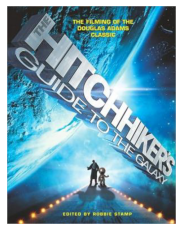

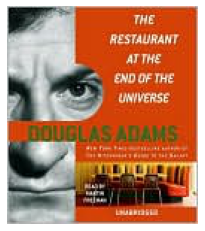

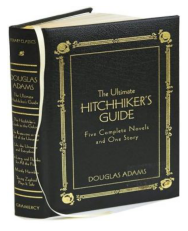

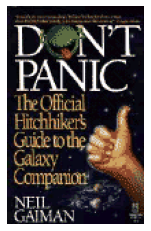

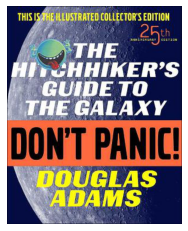

In [18]:
outputImgs(tfIdf2(testIsbn))

The Restaurant at the End of the Universe
The Hitchhiker's Guide to the Galaxy, Deluxe 25th Anniversary Edition
The Hitchhiker's Guide to the Galaxy, 25th Anniversary Edition
Evolution
Imago (Xenogenesis Series)


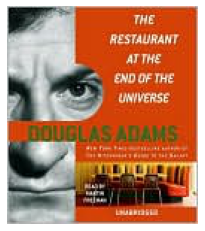

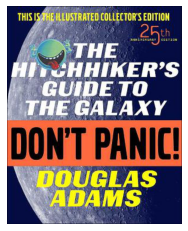

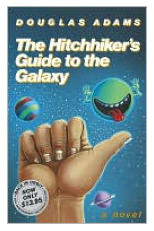

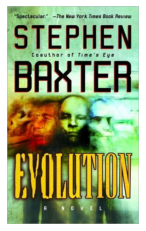

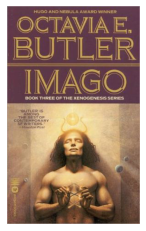

In [19]:
outputImgs(word2Vec_avg(testIsbn))

The Restaurant at the End of the Universe
The Hitchhiker's Guide to the Galaxy, Deluxe 25th Anniversary Edition
The Hitchhiker's Guide to the Galaxy, 25th Anniversary Edition
Evolution
Imago (Xenogenesis Series)


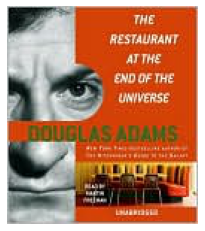

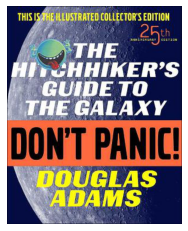

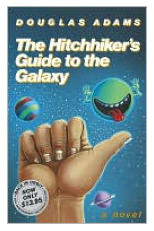

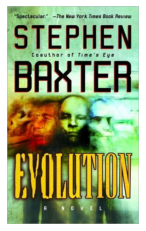

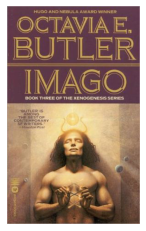

In [20]:
outputImgs(word2Vec_tfIdf(testIsbn))

The Restaurant at the End of the Universe
The Hitchhiker's Guide to the Galaxy, Deluxe 25th Anniversary Edition
The Hitchhiker's Guide to the Galaxy, 25th Anniversary Edition
Evolution
Imago (Xenogenesis Series)


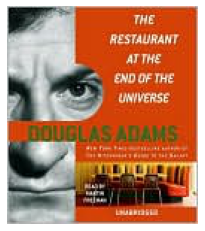

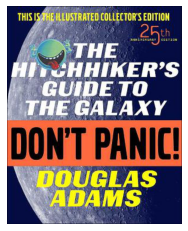

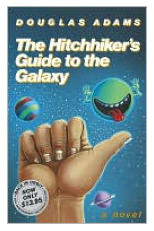

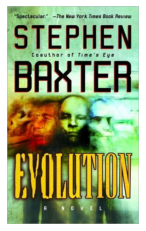

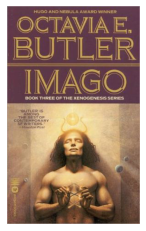

In [21]:
outputImgs(avg_glove(testIsbn))

Shalimar the Clown: A Novel
JoJo's Bizarre Adventure: Part 3--Stardust Crusaders (Single Volume Edition), Vol. 5: City of Death (5)
The Darker Nations: A People's History of the Third World (New Press People's History)
The Son Avenger: The Master of Hestviken: 4
Coyote Waits (Joe Leaphorn/Jim Chee Novels)


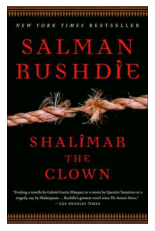

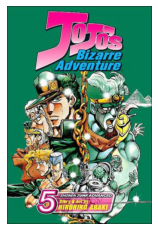

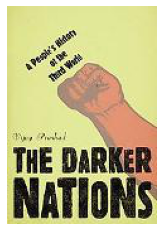

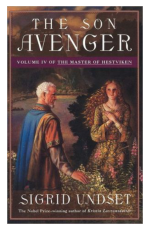

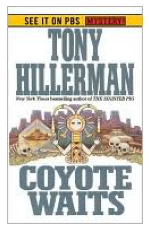

In [22]:
outputImgs(randomRec(testIsbn))

### Coverage
The coverage of each recommender is shown below. For detailed analysis of the coverage please see our report.

In [23]:
outList = []
for idx in range(5):
    curr = dictList[idx]
    output = {}
    for isbn in curr.keys():
        recos = [i for i, j in curr[isbn][:3]]
        for reco in recos:
            output[reco] = output.get(reco, 0) + 1
    outList.append(output)

In [24]:
idx = 0
for i in outList:
    vals = i.values()
    label = nameList[idx]
    idx += 1
    print(label+":", round(100*len(vals)/12148, 1), "%")

tfidf: 75.3 %
avg_w2v: 54.1 %
tfidf_w2v: 65.5 %
glove: 58.8 %
random: 95.1 %


### Hit Rate
The hit rate calculation takes a very long time.

In [25]:
ratings = pd.read_csv("finalRatings.csv", index_col=False)
userIDs = ratings['ID'].value_counts()[:10]

In [26]:
#Determines if a given user has rated a given book

def hasRated(userId, isbn):
    if isbn in ratings.loc[ratings['ID'] == userId]['ISBN'].values:
        return True
    else:
        return False

In [27]:
idx=0
for currDict in dictList:
    label = nameList[idx]
    idx += 1
    totalCount = 0
    rightCount = 0
    for isbn in tfidf.keys():
        for userID in userIDs.index:
            userReviews = ratings[ratings['ID'] == userID].values
            if hasRated(userID, isbn) == True:
                recos = [i for i, j in currDict[isbn]]
                totalCount += 1
                for rec_isbn in recos:
                    if str(rec_isbn) in userReviews:
                        rightCount += 1
    print(label + "Hit Rate:", round(100*rightCount/totalcount, 1)) 

tfidfHit Rate: 74.4
avg_w2vHit Rate: 29.5
tfidf_w2vHit Rate: 47.4
gloveHit Rate: 55.1
randomHit Rate: 12.2
